In [249]:
import pandas as pd

In [250]:
df = pd.read_excel("https://www.insee.fr/fr/statistiques/fichier/6524161/ia75.xlsx",
                   sheet_name="Figure 3", skiprows=3, skipfooter=7)

In [251]:

df = df.rename(columns={'Unnamed: 0': 'long_coicop',
               'Effet total.1': 'inflation_with_shelter', 'Effet total': 'inflation_without_shelter'})
df = df.set_index('long_coicop')
df = df.drop(["  électricité, gaz et autres combustibles",
             "  dépenses d'utilisation de véhicules"])

In [252]:
df['shelter_effect'] = df['inflation_without_shelter'] - \
    df['inflation_with_shelter']
df['shelter_direct_effect'] = df['Effet direct.1'] - \
    df['Effet direct']
df['shelter_indirect_effect'] = df['Effet indirect.1'] - \
    df['Effet indirect']

In [253]:

df = df.drop(['Unnamed: 1', 'Effet direct', 'Effet indirect',
             'Effet direct.1', 'Effet indirect.1'], axis=1)

In [254]:
# Create a list of values for the "coicop" column
coicop_values = ['CP{:02d}'.format(i) for i in range(1, len(df)+1)]

# Add the "coicop" column to the DataFrame
df['coicop'] = coicop_values

In [255]:

translations = {
    'Produits alimentaires et boissons non alcoolisées': 'Food and non-alcoholic beverages',
    'Boissons alcoolisées et tabac': 'Alcoholic beverages and tobacco',
    "Articles d'habillement et chaussures": 'Clothing and footwear',
    'Logement, eau, gaz, électricité et autres combustibles, dont : ': 'Housing, water, gas, electricity and other fuels',
    "Meubles, articles de ménage et entretien courant de l'habitation": 'Furniture, household equipment and maintenance',
    'Santé': 'Health',
    'Transport, dont : ': 'Transportation',
    'Communications': 'Communications',
    'Loisirs et culture': 'Recreation and culture',
    'Éducation': 'Education',
    'Hôtels, cafés et restaurants': 'Hotels, cafes and restaurants',
    'Autres biens et services': 'Other goods and services'
}

# Traduction de l'index avec le dictionnaire
df = df.rename(index=translations)

In [256]:

df = df.sort_values(by="inflation_with_shelter")
df = df.drop(["inflation_without_shelter", "shelter_effect"], axis=1)

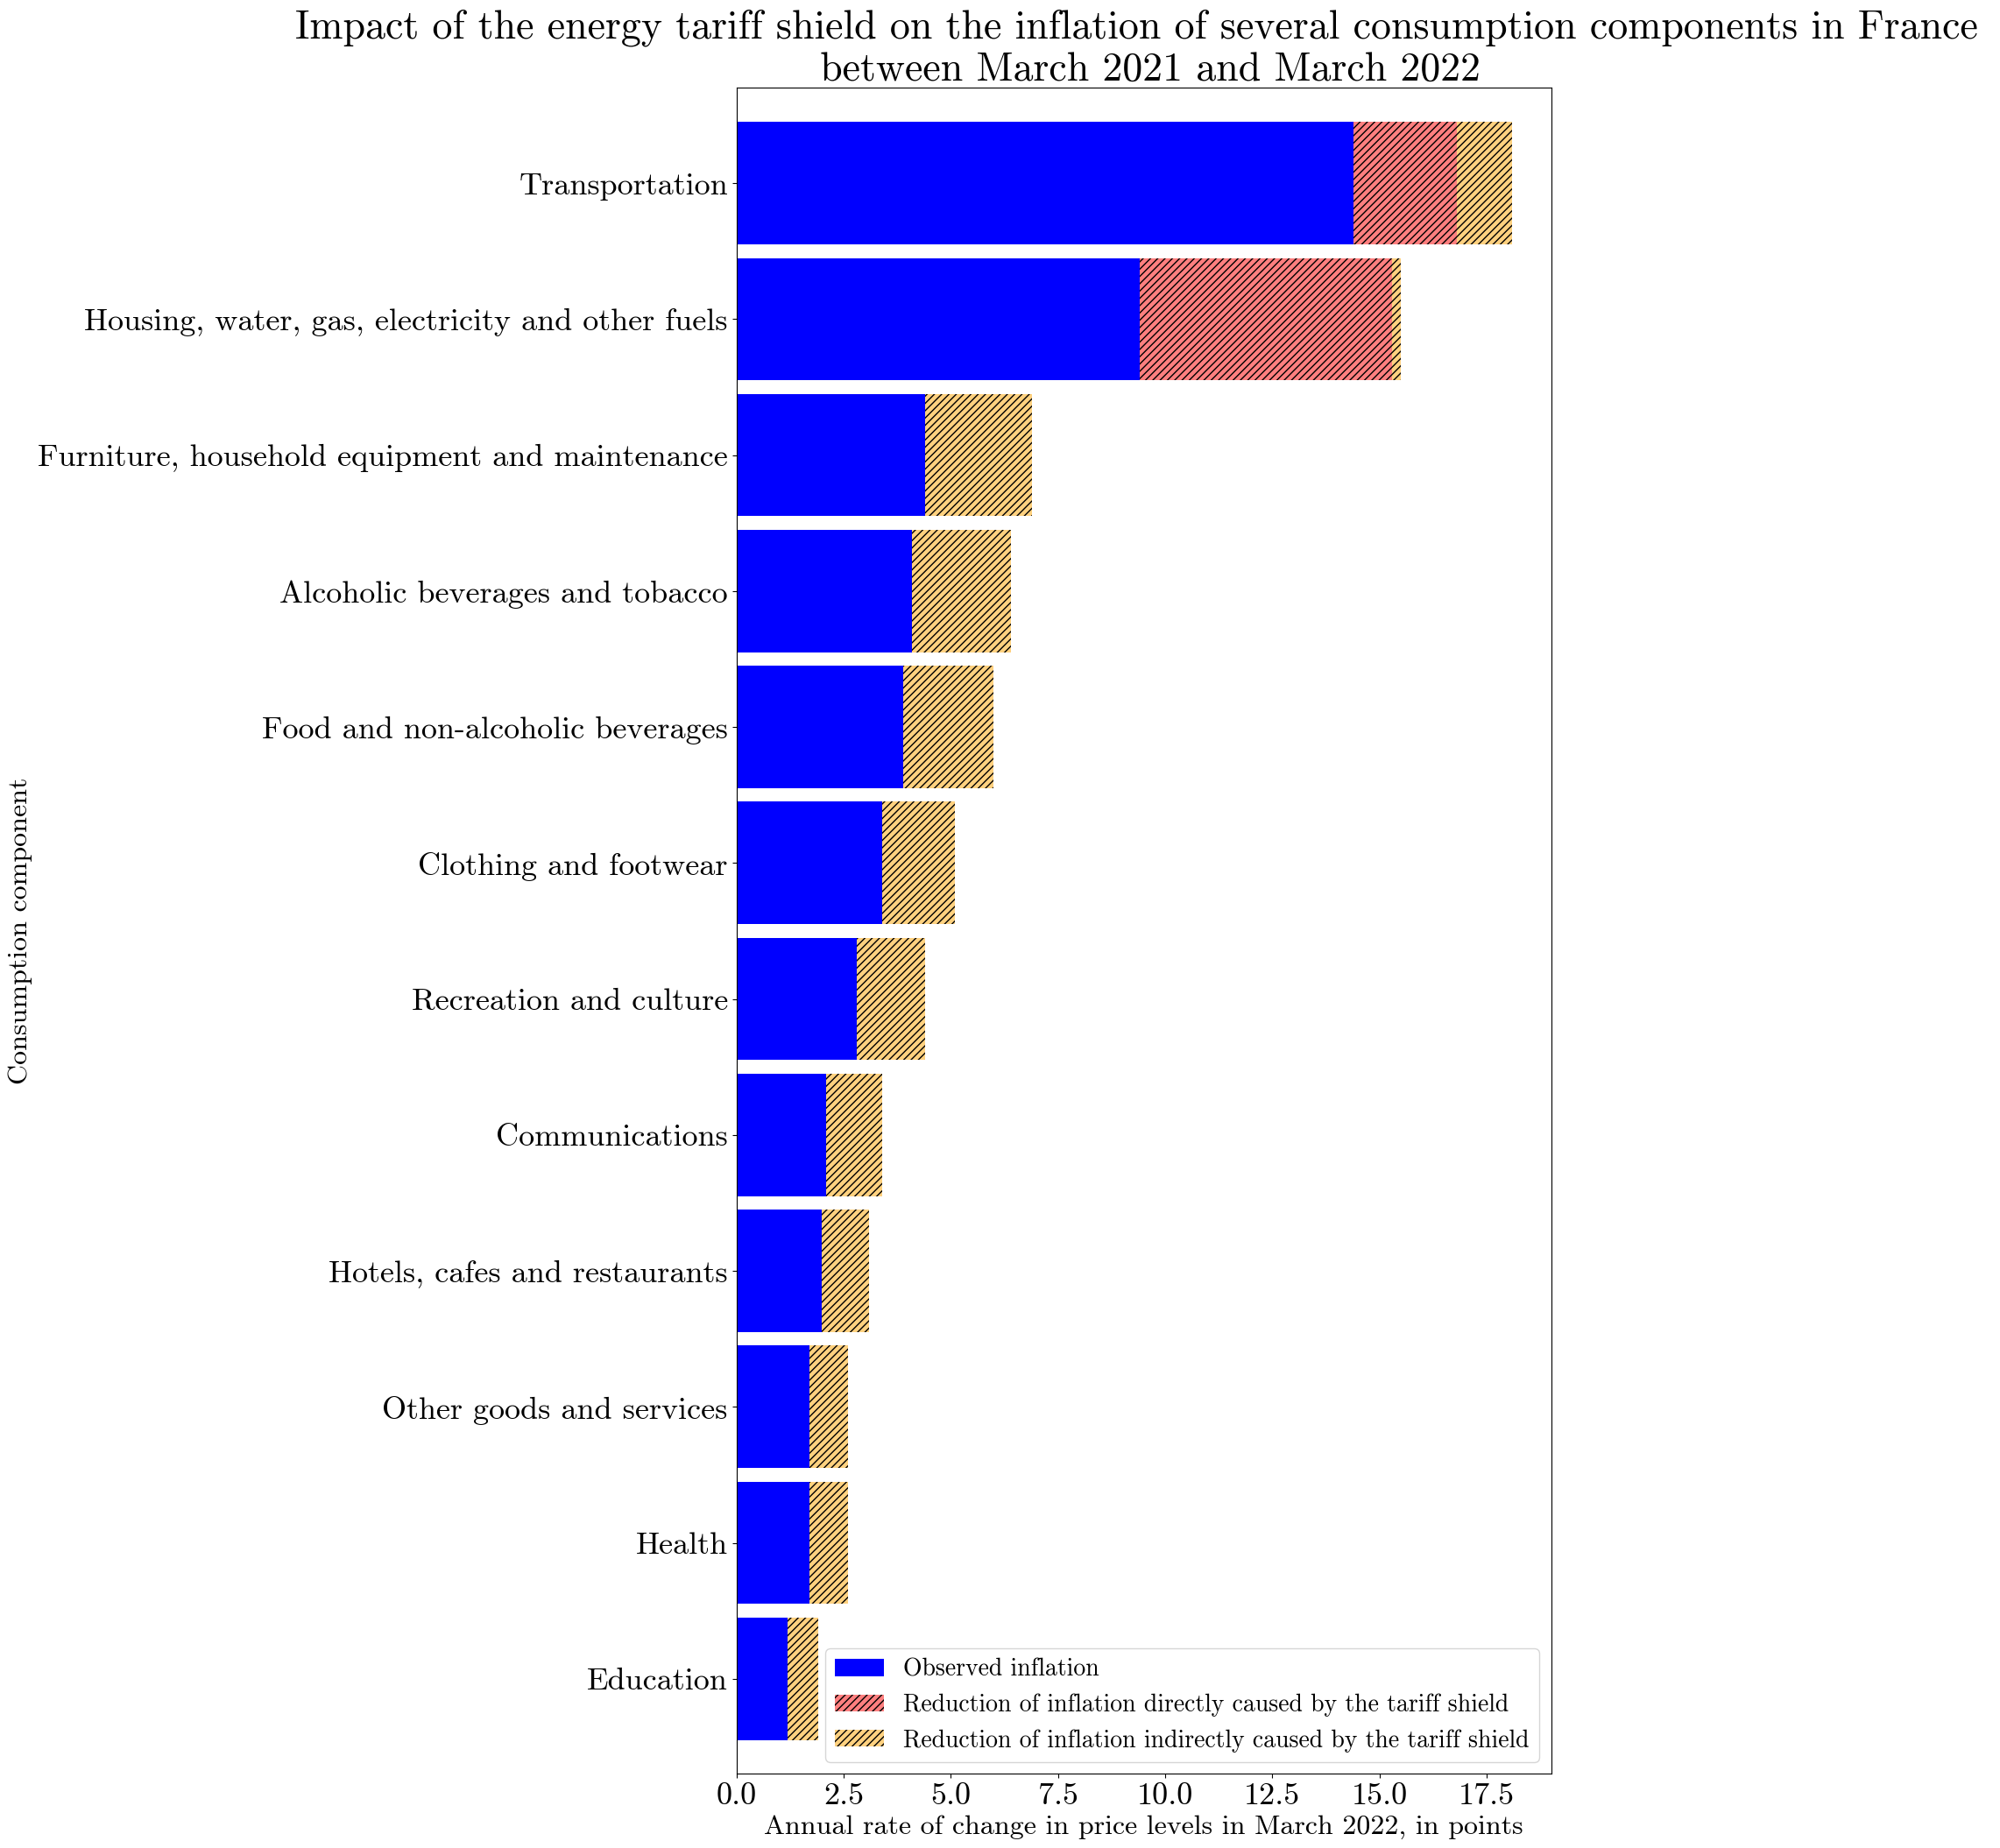

In [257]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'cmr10'
plt.rcParams.update({'font.size': 22})

col_names = {'inflation_with_shelter': 'Observed inflation',
             'shelter_direct_effect': 'Reduction of inflation directly caused by the tariff shield',
             'shelter_indirect_effect': 'Reduction of inflation indirectly caused by the tariff shield'}

# Create the stacked bar chart and assign the colors based on the column names
ax = df.plot(kind='barh', stacked=True, width=0.9, color={
             'inflation_with_shelter': 'blue',
             'shelter_direct_effect': 'red',
             'shelter_indirect_effect': 'orange'})

# Add hatches to the corresponding bars
for patch in ax.patches:
    if patch.get_facecolor() == (1.0, 0.0, 0.0, 1.0):  # red for shelter_direct_effect
        patch.set_hatch('////')
        patch.set_alpha(0.5)
    elif patch.get_facecolor() == (1.0, 0.6470588235294118, 0.0, 1.0):  # orange for shelter_indirect_effect
        patch.set_hatch('////')
        patch.set_alpha(0.5)

# Add axis labels and title
ax.set_xlabel('Annual rate of change in price levels in March 2022, in points', fontsize=23)
ax.set_ylabel('Consumption component', fontsize=23)
ax.set_title('Impact of the energy tariff shield on the inflation of several consumption components in France \n between March 2021 and March 2022', fontsize=33)

ax.tick_params(axis='y', which='major', labelsize=26)
ax.tick_params(axis='x', which='major', labelsize=26)

fig = plt.gcf()
fig.set_size_inches(12,25)

# Create a new legend and set the labels using the column name dictionary
handles, labels = ax.get_legend_handles_labels()
new_labels = [col_names[label] for label in labels]
ax.legend(handles, new_labels, fontsize=20)


plt.savefig(f'saved_figs/figure25.png', dpi=500, bbox_inches='tight')
# Show the chart
plt.show()